# Mercury Transit Data Collection Notebook

To determine the Astronomical Unit from photographs of the transit of Mercury, we analyzed ephemeris data to determine mercury's orbital period, and the distance between the two observatories project in a direction perpendicular to the vector from the Earth to the Sun, in order to do paralax analysis.

## Setup

In [6]:
!pip3 install ephem
!pip3 install pytz
!pip3 install astropy
!pip3 install pandas
!pip3 install numpy
!pip3 install nvector
!pip3 install sympy
!pip3 install tqdm

In [0]:
import numpy as np
from datetime import datetime
import pandas as pd
import ephem
from sympy import Plane, Point3D
import nvector as nv
from pytz import timezone
from astropy import coordinates as coord
from astropy.coordinates import solar_system_ephemeris, EarthLocation, get_body_barycentric, get_body, get_moon, SkyCoord, BarycentricMeanEcliptic
from astropy import units as u
from astropy.time import Time
from astropy.table import Table
from tqdm.notebook import tqdm as tqdm_notebook

## Mercury Orbital Period

In [0]:
def dot_to_angle(row):
    return np.arcsin(row)*360/(2*np.pi)

def moon_alt(date):
    observer = ephem.city('San Francisco')
    observer.date = ephem.date(date)
    return float(ephem.Mercury(observer).alt)

In [14]:
# Find Sun and Mercury positions for all of 2018, in order to graph Mercury's Ecliptic Latitude as a function of time
dates = pd.date_range(start='1/1/2018', end='1/2/2019', freq='H',tz='UTC')

coords_ecl = []

loc = EarthLocation.of_site('greenwich') 

for date in tqdm_notebook(dates):

    with solar_system_ephemeris.set('builtin'):
        m = get_body('mercury', Time(date), loc)
        s = get_body('sun', Time(date), loc)
        # convert coordinates to eclipitic frame, and save
        merc = SkyCoord(m).transform_to(BarycentricMeanEcliptic)
        sun = SkyCoord(s).transform_to(BarycentricMeanEcliptic)
    
    coords_ecl.append([float(merc.lat/u.deg), float(merc.lon/u.deg),float(sun.lat/u.deg), float(sun.lon/u.deg)])

mercury_pos = pd.DataFrame(coords_ecl, columns=['ecl_lat_merc','ecl_lon_merc','ecl_lat_sun','ecl_lon_sun'])
mercury_pos['date_utc'] = dates
mercury_pos['lat_diff'] = np.abs(mercury_pos['ecl_lat_merc'] - mercury_pos['ecl_lat_sun'])
mercury_pos

,ecl_lat_merc,ecl_lon_merc,ecl_lat_sun,ecl_lon_sun,date_utc,lat_diff
0,5.156182,180.225433,-1.077748,73.613324,2018-01-01 00:00:00+00:00,6.233931
1,5.142659,180.391694,-1.077673,73.615950,2018-01-01 01:00:00+00:00,6.220332
2,5.129108,180.557754,-1.077598,73.618575,2018-01-01 02:00:00+00:00,6.206706
3,5.115529,180.723612,-1.077523,73.621201,2018-01-01 03:00:00+00:00,6.193052
4,5.101923,180.889270,-1.077448,73.623827,2018-01-01 04:00:00+00:00,6.179371
...,...,...,...,...,...,...
8780,0.050919,227.125365,-0.438768,95.858299,2019-01-01 20:00:00+00:00,0.489687
8781,0.035798,227.248622,-0.438697,95.860735,2019-01-01 21:00:00+00:00,0.474496
8782,0.020685,227.371815,-0.438626,95.863171,2019-01-01 22:00:00+00:00,0.459311
8783,0.005579,227.494946,-0.438555,95.865606,2019-01-01 23:00:00+00:00,0.444134


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])


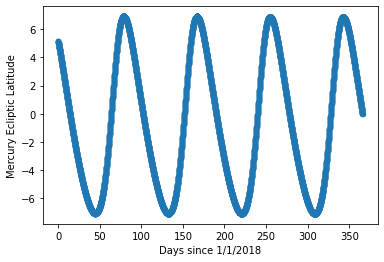

In [15]:
# Graph ecliptic latitude vs. time
mercury_pos['Mercury Ecliptic Latitude'] = mercury_pos['ecl_lat_merc']
mercury_pos['Days since 1/1/2018'] = mercury_pos.index/24
mercury_pos.plot.scatter('Days since 1/1/2018','Mercury Ecliptic Latitude')


In [16]:
# Log each time mercury crosses from above to below the ecliptic plane (ecliptic latitude goes from > 0 to < 0),
# in order to find mercury's orbital period

prev_date = mercury_pos['date_utc'].values[0]
date_gaps = []

for i in range(mercury_pos.shape[0]-2):
    # if mercury is going below the ecliptic plane, log the time
    if (((mercury_pos['ecl_lat_merc'].values[i] - mercury_pos['ecl_lat_merc'].values[i+1] > 0 and 
        mercury_pos['ecl_lat_merc'].values[i+1] - mercury_pos['ecl_lat_merc'].values[i+2] < 0))):
        
        print(mercury_pos['date_utc'].values[i])
        date_gaps.append((mercury_pos['date_utc'].values[i] - prev_date)/ np.timedelta64(1, 'D'))
        prev_date = mercury_pos['date_utc'].values[i]

# Observed Orbital Period (in days)
np.mean(date_gaps[1:4])

2018-02-14T12:00:00.000000000
2018-05-13T12:00:00.000000000
2018-08-09T11:00:00.000000000
2018-11-05T11:00:00.000000000


87.9861111111111

## Oberservation Site Distance

In [0]:
# Project the vector between the two sites on Earth onto a plane perpendicular to the vector from site A (Big Bear Solar Observatory) to the sun,
# then measure the planar distance


r = 6371e3 #radius of the earth
wgs84 = nv.FrameE(a=r, f=0)
pointA = wgs84.GeoPoint(latitude=34.2614, longitude=-116.9212, degrees=True) # Big Bear
pointB = wgs84.GeoPoint(latitude=-30.1690, longitude=-70.8063, degrees=True) # cerro tololo
p_AB_N = pointA.delta_to(pointB)
dist, azi_a, b_azi = pointA.distance_and_azimuth(pointB)
dist= dist/1000
vec_a = pointA.to_ecef_vector().pvector.ravel()/np.linalg.norm(pointA.to_ecef_vector().pvector.ravel())
vec_b = pointB.to_ecef_vector().pvector.ravel()/np.linalg.norm(pointB.to_ecef_vector().pvector.ravel())
theta = dist/r
dist_d = 2*r*np.sin(theta/2)
alt_a = -np.pi/2+np.arcsin(np.sin(theta)*r/dist_d)
alt_a/np.pi*180, azi_a*180/np.pi, (np.pi-theta)/2
direction_vector = spherical_to_cartesian(azi_a,alt_a)/np.linalg.norm(spherical_to_cartesian(azi_a,alt_a))*dist_d
a_plane = Plane(Point3D(0, 0, 0), normal_vector=spherical_to_cartesian(azi_a,alt_a))
pointA.distance_and_azimuth

<bound method GeoPoint.distance_and_azimuth of <nvector.objects.GeoPoint object at 0x117cb22d0>>

In [0]:
def spherical_to_cartesian(azi,alt):
    # Converts azimuth, altitude coordinates (also know as azimuth, elevation coordinates) to cartesian coordinates (x,y,z)
    return np.cos(alt)*np.cos(azi),np.cos(alt)*np.sin(azi),np.sin(alt)

def find_dist(date):
    # Find the distance between the sites on the perpendicular plane given some date

    observer = ephem.city('San Francisco')
    observer.date = ephem.date(date)
    a_plane = Plane(Point3D(0, 0, 0), normal_vector=spherical_to_cartesian(ephem.Sun(observer).az,ephem.Sun(observer).alt))

    new_point = a_plane.projection(direction_vector)
    return np.linalg.norm([float(new_point.x),float(new_point.y),float(new_point.z)])
    

coord_b = spherical_to_cartesian(azi_a,alt_a)

In [0]:
# List of Transit image file names, used to find each image's timestamp
filenames = "20160509111214Th.jpg,20160509111314Th.jpg,20160509111414Th.jpg,20160509111514Th.jpg,20160509111614Th.jpg,20160509111714Th.jpg,20160509111814Th.jpg,20160509111914Th.jpg,20160509112014Th.jpg,20160509112114Th.jpg,20160509112214Th.jpg,20160509112314Th.jpg,20160509112414Th.jpg,20160509112514Th.jpg,20160509112614Th.jpg,20160509112714Th.jpg,20160509112814Th.jpg,20160509112914Th.jpg,20160509113014Th.jpg,20160509113114Th.jpg,20160509113214Th.jpg,20160509113314Th.jpg,20160509113414Th.jpg,20160509113514Th.jpg,20160509113614Th.jpg,20160509113714Th.jpg,20160509113814Th.jpg,20160509113914Th.jpg,20160509114014Th.jpg,20160509114114Th.jpg,20160509114914Th.jpg,20160509115014Th.jpg,20160509115114Th.jpg,20160509115214Th.jpg,20160509115314Th.jpg,20160509115414Th.jpg,20160509115514Th.jpg,20160509115614Th.jpg,20160509115714Th.jpg,20160509115814Th.jpg,20160509115914Th.jpg,20160509120014Th.jpg,20160509120114Th.jpg,20160509120214Th.jpg,20160509120314Th.jpg,20160509120414Th.jpg,20160509120514Th.jpg,20160509120614Th.jpg,20160509120714Th.jpg,20160509120814Th.jpg,20160509120914Th.jpg,20160509121014Th.jpg,20160509121114Th.jpg,20160509121214Th.jpg,20160509121314Th.jpg,20160509121414Th.jpg,20160509121514Th.jpg,20160509121614Th.jpg,20160509121714Th.jpg,20160509121814Th.jpg,20160509121914Th.jpg,20160509122014Th.jpg,20160509122114Th.jpg,20160509122214Th.jpg,20160509122314Th.jpg,20160509122414Th.jpg,20160509122514Th.jpg,20160509122614Th.jpg,20160509122714Th.jpg,20160509122814Th.jpg,20160509122914Th.jpg,20160509123014Th.jpg,20160509123114Th.jpg,20160509123214Th.jpg,20160509123314Th.jpg,20160509123414Th.jpg,20160509123514Th.jpg,20160509123614Th.jpg,20160509123714Th.jpg,20160509123814Th.jpg,20160509123914Th.jpg,20160509124014Th.jpg,20160509124114Th.jpg,20160509124214Th.jpg,20160509124314Th.jpg,20160509124414Th.jpg,20160509124514Th.jpg,20160509124614Th.jpg,20160509124714Th.jpg,20160509124814Th.jpg,20160509124914Th.jpg,20160509125014Th.jpg,20160509125114Th.jpg,20160509125214Th.jpg,20160509125314Th.jpg,20160509125414Th.jpg,20160509125514Th.jpg,20160509125614Th.jpg,20160509125714Th.jpg,20160509125734Ch.jpg,20160509125814Th.jpg,20160509125834Ch.jpg,20160509125914Th.jpg,20160509125934Ch.jpg,20160509130014Th.jpg,20160509130034Ch.jpg,20160509130114Th.jpg,20160509130134Ch.jpg,20160509130214Th.jpg,20160509130234Ch.jpg,20160509130314Th.jpg,20160509130334Ch.jpg,20160509130414Th.jpg,20160509130434Ch.jpg,20160509130514Th.jpg,20160509130534Ch.jpg,20160509130614Th.jpg,20160509130634Ch.jpg,20160509130714Th.jpg,20160509130734Ch.jpg,20160509130814Th.jpg,20160509130834Ch.jpg,20160509130914Th.jpg,20160509130934Ch.jpg,20160509131014Th.jpg,20160509131114Th.jpg,20160509131214Th.jpg,20160509131314Th.jpg,20160509131414Th.jpg,20160509131514Th.jpg,20160509131614Th.jpg,20160509131634Ch.jpg,20160509131714Th.jpg,20160509131734Ch.jpg,20160509131814Th.jpg,20160509131834Ch.jpg,20160509131914Th.jpg,20160509131934Ch.jpg,20160509132014Th.jpg,20160509132034Ch.jpg,20160509132114Th.jpg,20160509132134Ch.jpg,20160509132214Th.jpg,20160509132234Ch.jpg,20160509132314Th.jpg,20160509132334Ch.jpg,20160509132414Th.jpg,20160509132434Ch.jpg,20160509132514Th.jpg,20160509132534Ch.jpg,20160509132614Th.jpg,20160509132634Ch.jpg,20160509132734Ch.jpg,20160509132834Ch.jpg,20160509132914Th.jpg,20160509132934Ch.jpg,20160509133014Th.jpg,20160509133034Ch.jpg,20160509133114Th.jpg,20160509133134Ch.jpg,20160509133214Th.jpg,20160509133234Ch.jpg,20160509133314Th.jpg,20160509133334Ch.jpg,20160509133414Th.jpg,20160509133434Ch.jpg,20160509133514Th.jpg,20160509133534Ch.jpg,20160509133614Th.jpg,20160509133634Ch.jpg,20160509133714Th.jpg,20160509133734Ch.jpg,20160509133814Th.jpg,20160509133834Ch.jpg,20160509133914Th.jpg,20160509133934Ch.jpg,20160509134014Th.jpg,20160509134034Ch.jpg,20160509134114Th.jpg,20160509134134Ch.jpg,20160509134214Th.jpg,20160509134234Ch.jpg,20160509134314Th.jpg,20160509134334Ch.jpg,20160509134414Th.jpg,20160509134434Ch.jpg,20160509134514Th.jpg,20160509134534Ch.jpg,20160509134614Th.jpg,20160509134634Ch.jpg,20160509134734Ch.jpg,20160509134814Th.jpg,20160509134834Ch.jpg,20160509134914Th.jpg,20160509134934Ch.jpg,20160509134954Bh.jpg,20160509135014Th.jpg,20160509135034Ch.jpg,20160509135054Bh.jpg,20160509135114Th.jpg,20160509135134Ch.jpg,20160509135154Bh.jpg,20160509135214Th.jpg,20160509135234Ch.jpg,20160509135254Bh.jpg,20160509135314Th.jpg,20160509135334Ch.jpg,20160509135354Bh.jpg,20160509135414Th.jpg,20160509135434Ch.jpg,20160509135454Bh.jpg,20160509135514Th.jpg,20160509135534Ch.jpg,20160509135554Bh.jpg,20160509135614Th.jpg,20160509135634Ch.jpg,20160509135654Bh.jpg,20160509135714Th.jpg,20160509135734Ch.jpg,20160509135754Bh.jpg,20160509135814Th.jpg,20160509135834Ch.jpg,20160509135854Bh.jpg,20160509135914Th.jpg,20160509135934Ch.jpg,20160509135954Bh.jpg,20160509140014Th.jpg,20160509140034Ch.jpg,20160509140054Bh.jpg,20160509140114Th.jpg,20160509140134Ch.jpg,20160509140154Bh.jpg,20160509140214Th.jpg,20160509140234Ch.jpg,20160509140254Bh.jpg,20160509140314Th.jpg,20160509140334Ch.jpg,20160509140354Bh.jpg,20160509140414Th.jpg,20160509140434Ch.jpg,20160509140454Bh.jpg,20160509140514Th.jpg,20160509140534Ch.jpg,20160509140554Bh.jpg,20160509140614Th.jpg,20160509140634Ch.jpg,20160509140654Bh.jpg,20160509140714Th.jpg,20160509140734Ch.jpg,20160509140754Bh.jpg,20160509140814Th.jpg,20160509140834Ch.jpg,20160509140854Bh.jpg,20160509140914Th.jpg,20160509140934Ch.jpg,20160509140954Bh.jpg,20160509141014Th.jpg,20160509141054Bh.jpg,20160509141114Th.jpg,20160509141154Bh.jpg,20160509141214Th.jpg,20160509141254Bh.jpg,20160509141314Th.jpg,20160509141354Bh.jpg,20160509141414Th.jpg,20160509141454Bh.jpg,20160509141514Th.jpg,20160509141554Bh.jpg,20160509141614Th.jpg,20160509141654Bh.jpg,20160509141714Th.jpg,20160509141734Ch.jpg,20160509141754Bh.jpg,20160509141814Th.jpg,20160509141834Ch.jpg,20160509141854Bh.jpg,20160509141914Th.jpg,20160509141934Ch.jpg,20160509141954Bh.jpg,20160509142014Th.jpg,20160509142034Ch.jpg,20160509142054Bh.jpg,20160509142114Th.jpg,20160509142134Ch.jpg,20160509142154Bh.jpg,20160509142214Th.jpg,20160509142234Ch.jpg,20160509142254Bh.jpg,20160509142314Th.jpg,20160509142334Ch.jpg,20160509142354Bh.jpg,20160509142414Th.jpg,20160509142434Ch.jpg,20160509142454Bh.jpg,20160509142514Th.jpg,20160509142534Ch.jpg,20160509142614Th.jpg,20160509142634Ch.jpg,20160509142654Bh.jpg,20160509142714Th.jpg,20160509142734Ch.jpg,20160509142754Bh.jpg,20160509142814Th.jpg,20160509142834Ch.jpg,20160509142854Bh.jpg,20160509142914Th.jpg,20160509142934Ch.jpg,20160509142954Bh.jpg,20160509143014Th.jpg,20160509143054Bh.jpg,20160509143114Th.jpg,20160509143154Bh.jpg,20160509143214Th.jpg,20160509143254Bh.jpg,20160509143314Th.jpg,20160509143354Bh.jpg,20160509143414Th.jpg,20160509143454Bh.jpg,20160509143514Th.jpg,20160509143554Bh.jpg,20160509143614Th.jpg,20160509143714Th.jpg,20160509143814Th.jpg,20160509143914Th.jpg,20160509144014Th.jpg,20160509144114Th.jpg,20160509144214Th.jpg,20160509144314Th.jpg,20160509144354Bh.jpg,20160509144414Th.jpg,20160509144454Bh.jpg,20160509144514Th.jpg,20160509144554Bh.jpg,20160509144614Th.jpg,20160509144654Bh.jpg,20160509144714Th.jpg,20160509144754Bh.jpg,20160509144814Th.jpg,20160509144854Bh.jpg,20160509144914Th.jpg,20160509144954Bh.jpg,20160509145014Th.jpg,20160509145054Bh.jpg,20160509145114Th.jpg,20160509145154Bh.jpg,20160509145214Th.jpg,20160509145254Bh.jpg,20160509145314Th.jpg,20160509145354Bh.jpg,20160509145414Th.jpg,20160509145454Bh.jpg,20160509145514Th.jpg,20160509145554Bh.jpg,20160509145614Th.jpg,20160509145654Bh.jpg,20160509145714Th.jpg,20160509145754Bh.jpg,20160509145814Th.jpg,20160509145854Bh.jpg,20160509145914Th.jpg,20160509145954Bh.jpg,20160509150014Th.jpg,20160509150054Bh.jpg,20160509150114Th.jpg,20160509150154Bh.jpg,20160509150214Th.jpg,20160509150254Bh.jpg,20160509150314Th.jpg,20160509150354Bh.jpg,20160509150414Th.jpg,20160509150454Bh.jpg,20160509150514Th.jpg,20160509150554Bh.jpg,20160509150614Th.jpg,20160509150654Bh.jpg,20160509150714Th.jpg,20160509150754Bh.jpg,20160509150814Th.jpg,20160509150854Bh.jpg,20160509150914Th.jpg,20160509150954Bh.jpg,20160509151014Th.jpg,20160509151054Bh.jpg,20160509151114Th.jpg,20160509151154Bh.jpg,20160509151214Th.jpg,20160509151254Bh.jpg,20160509151314Th.jpg,20160509151354Bh.jpg,20160509151414Th.jpg,20160509151454Bh.jpg,20160509151514Th.jpg,20160509151554Bh.jpg,20160509151614Th.jpg,20160509151654Bh.jpg,20160509151714Th.jpg,20160509151754Bh.jpg,20160509151814Th.jpg,20160509151854Bh.jpg,20160509151914Th.jpg,20160509151954Bh.jpg,20160509152014Th.jpg,20160509152054Bh.jpg,20160509152114Th.jpg,20160509152154Bh.jpg,20160509152214Th.jpg,20160509152254Bh.jpg,20160509152314Th.jpg,20160509152354Bh.jpg,20160509152414Th.jpg,20160509152454Bh.jpg,20160509152514Th.jpg,20160509152534Ch.jpg,20160509152554Bh.jpg,20160509152614Th.jpg,20160509152634Ch.jpg,20160509152654Bh.jpg,20160509152714Th.jpg,20160509152734Ch.jpg,20160509152754Bh.jpg,20160509152814Th.jpg,20160509152854Bh.jpg,20160509152914Th.jpg,20160509152954Bh.jpg,20160509153014Th.jpg,20160509153054Bh.jpg,20160509153114Th.jpg,20160509153154Bh.jpg,20160509153214Th.jpg,20160509153254Bh.jpg,20160509153314Th.jpg,20160509153334Ch.jpg,20160509153354Bh.jpg,20160509153414Th.jpg,20160509153434Ch.jpg,20160509153454Bh.jpg,20160509153514Th.jpg,20160509153554Bh.jpg,20160509153614Th.jpg,20160509153654Bh.jpg,20160509153714Th.jpg,20160509153754Bh.jpg,20160509153814Th.jpg,20160509153854Bh.jpg,20160509153914Th.jpg,20160509153954Bh.jpg,20160509154014Th.jpg,20160509154034Ch.jpg,20160509154054Bh.jpg,20160509154114Th.jpg,20160509154134Ch.jpg,20160509154154Bh.jpg,20160509154214Th.jpg,20160509154234Ch.jpg,20160509154254Bh.jpg,20160509154314Th.jpg,20160509154334Ch.jpg,20160509154354Bh.jpg,20160509154414Th.jpg,20160509154434Ch.jpg,20160509154454Bh.jpg,20160509154514Th.jpg,20160509154554Bh.jpg,20160509154614Th.jpg,20160509154654Bh.jpg,20160509154714Th.jpg,20160509154754Bh.jpg,20160509154814Th.jpg,20160509154854Bh.jpg,20160509154914Th.jpg,20160509154954Bh.jpg,20160509155014Th.jpg,20160509155054Bh.jpg,20160509155114Th.jpg,20160509155134Ch.jpg,20160509155154Bh.jpg,20160509155214Th.jpg,20160509155234Ch.jpg,20160509155254Bh.jpg,20160509155334Ch.jpg,20160509155354Bh.jpg,20160509155434Ch.jpg,20160509155454Bh.jpg,20160509155534Ch.jpg,20160509155554Bh.jpg,20160509155634Ch.jpg,20160509155654Bh.jpg,20160509155734Ch.jpg,20160509155754Bh.jpg,20160509155834Ch.jpg,20160509155854Bh.jpg,20160509155934Ch.jpg,20160509155954Bh.jpg,20160509160034Ch.jpg,20160509160054Bh.jpg,20160509160134Ch.jpg,20160509160154Bh.jpg,20160509160214Th.jpg,20160509160234Ch.jpg,20160509160254Bh.jpg,20160509160314Th.jpg,20160509160334Ch.jpg,20160509160354Bh.jpg,20160509160434Ch.jpg,20160509160454Bh.jpg,20160509160534Ch.jpg,20160509160554Bh.jpg,20160509160634Ch.jpg,20160509160654Bh.jpg,20160509160714Th.jpg,20160509160754Bh.jpg,20160509160854Bh.jpg,20160509160954Bh.jpg,20160509161054Bh.jpg,20160509161154Bh.jpg,20160509161254Bh.jpg,20160509161354Bh.jpg,20160509161454Bh.jpg,20160509161554Bh.jpg,20160509161654Bh.jpg,20160509161754Bh.jpg,20160509161854Bh.jpg,20160509161954Bh.jpg,20160509162054Bh.jpg,20160509162134Ch.jpg,20160509162234Ch.jpg,20160509162434Ch.jpg,20160509162534Ch.jpg,20160509162614Th.jpg,20160509162634Ch.jpg,20160509162734Ch.jpg,20160509162834Ch.jpg,20160509162854Bh.jpg,20160509162934Ch.jpg,20160509162954Bh.jpg,20160509163034Ch.jpg,20160509163054Bh.jpg,20160509163134Ch.jpg,20160509163154Bh.jpg,20160509163234Ch.jpg,20160509163254Bh.jpg,20160509163354Bh.jpg,20160509163454Bh.jpg,20160509163554Bh.jpg,20160509163654Bh.jpg,20160509163754Bh.jpg,20160509163814Th.jpg,20160509163854Bh.jpg,20160509163914Mh.jpg,20160509163954Bh.jpg,20160509164014Mh.jpg,20160509164054Bh.jpg,20160509164114Mh.jpg,20160509164154Bh.jpg,20160509164214Mh.jpg,20160509164214Th.jpg,20160509164254Bh.jpg,20160509164314Mh.jpg,20160509164314Th.jpg,20160509164354Bh.jpg,20160509164414Mh.jpg,20160509164414Th.jpg,20160509164454Bh.jpg,20160509164514Mh.jpg,20160509164554Bh.jpg,20160509164614Mh.jpg,20160509164654Bh.jpg,20160509164714Mh.jpg,20160509164714Th.jpg,20160509164754Bh.jpg,20160509164814Mh.jpg,20160509164814Th.jpg,20160509164834Ch.jpg,20160509164854Bh.jpg,20160509164914Mh.jpg,20160509164954Bh.jpg,20160509165014Mh.jpg,20160509165014Th.jpg,20160509165054Bh.jpg,20160509165114Mh.jpg,20160509165134Ch.jpg,20160509165154Bh.jpg,20160509165214Mh.jpg,20160509165254Bh.jpg,20160509165314Mh.jpg,20160509165354Bh.jpg,20160509165414Mh.jpg,20160509165454Bh.jpg,20160509165514Mh.jpg,20160509165554Bh.jpg,20160509165614Mh.jpg,20160509165614Th.jpg,20160509165654Bh.jpg,20160509165714Mh.jpg,20160509165734Ch.jpg,20160509165754Bh.jpg,20160509165814Mh.jpg,20160509165834Ch.jpg,20160509165854Bh.jpg,20160509165914Mh.jpg,20160509165914Th.jpg,20160509165934Ch.jpg,20160509165954Bh.jpg,20160509170014Mh.jpg,20160509170034Ch.jpg,20160509170054Bh.jpg,20160509170114Mh.jpg,20160509170134Ch.jpg,20160509170154Bh.jpg,20160509170214Mh.jpg,20160509170234Ch.jpg,20160509170254Bh.jpg,20160509170314Mh.jpg,20160509170314Th.jpg,20160509170334Ch.jpg,20160509170354Bh.jpg,20160509170414Mh.jpg,20160509170434Ch.jpg,20160509170454Bh.jpg,20160509170514Mh.jpg,20160509170534Ch.jpg,20160509170554Bh.jpg,20160509170614Mh.jpg,20160509170634Ch.jpg,20160509170654Bh.jpg,20160509170714Mh.jpg,20160509170734Ch.jpg,20160509170754Bh.jpg,20160509170814Mh.jpg,20160509170854Bh.jpg,20160509170914Mh.jpg,20160509170954Bh.jpg,20160509171014Mh.jpg,20160509171054Bh.jpg,20160509171114Mh.jpg,20160509171154Bh.jpg,20160509171214Mh.jpg,20160509171254Bh.jpg,20160509171314Mh.jpg,20160509171354Bh.jpg,20160509171414Mh.jpg,20160509171414Th.jpg,20160509171454Bh.jpg,20160509171514Mh.jpg,20160509171514Th.jpg,20160509171554Bh.jpg,20160509171614Mh.jpg,20160509171654Bh.jpg,20160509171714Mh.jpg,20160509171754Bh.jpg,20160509171814Mh.jpg,20160509171854Bh.jpg,20160509171914Mh.jpg,20160509171914Th.jpg,20160509171954Bh.jpg,20160509172014Mh.jpg,20160509172014Th.jpg,20160509172054Bh.jpg,20160509172114Mh.jpg,20160509172154Bh.jpg,20160509172214Mh.jpg,20160509172254Bh.jpg,20160509172314Mh.jpg,20160509172314Th.jpg,20160509172354Bh.jpg,20160509172414Mh.jpg,20160509172414Th.jpg,20160509172454Bh.jpg,20160509172514Mh.jpg,20160509172554Bh.jpg,20160509172614Mh.jpg,20160509172614Th.jpg,20160509172654Bh.jpg,20160509172714Mh.jpg,20160509172754Bh.jpg,20160509172814Mh.jpg,20160509172854Bh.jpg,20160509172914Mh.jpg,20160509172914Th.jpg,20160509172934Ch.jpg,20160509172954Bh.jpg,20160509173014Mh.jpg,20160509173014Th.jpg,20160509173054Bh.jpg,20160509173114Mh.jpg,20160509173114Th.jpg,20160509173154Bh.jpg,20160509173214Mh.jpg,20160509173254Bh.jpg,20160509173314Mh.jpg,20160509173354Bh.jpg,20160509173414Mh.jpg,20160509173434Ch.jpg,20160509173454Bh.jpg,20160509173514Mh.jpg,20160509173514Th.jpg,20160509173534Ch.jpg,20160509173554Bh.jpg,20160509173614Mh.jpg,20160509173634Ch.jpg,20160509173654Bh.jpg,20160509173714Mh.jpg,20160509173734Ch.jpg,20160509173754Bh.jpg,20160509173814Mh.jpg,20160509173814Th.jpg,20160509173834Ch.jpg,20160509173854Bh.jpg,20160509173914Mh.jpg,20160509173914Th.jpg,20160509173954Bh.jpg,20160509174014Mh.jpg,20160509174014Th.jpg,20160509174054Bh.jpg,20160509174114Mh.jpg,20160509174114Th.jpg,20160509174154Bh.jpg,20160509174214Mh.jpg,20160509174214Th.jpg,20160509174254Bh.jpg,20160509174314Mh.jpg,20160509174314Th.jpg,20160509174354Bh.jpg,20160509174414Mh.jpg,20160509174414Th.jpg,20160509174454Bh.jpg,20160509174514Mh.jpg,20160509174514Th.jpg,20160509174554Bh.jpg,20160509174614Mh.jpg,20160509174614Th.jpg,20160509174634Ch.jpg,20160509174654Bh.jpg,20160509174714Mh.jpg,20160509174714Th.jpg,20160509174734Ch.jpg,20160509174754Bh.jpg,20160509174814Mh.jpg,20160509174814Th.jpg,20160509174834Ch.jpg,20160509174854Bh.jpg,20160509174914Mh.jpg,20160509174914Th.jpg,20160509174954Bh.jpg,20160509175014Mh.jpg,20160509175014Th.jpg,20160509175054Bh.jpg,20160509175114Mh.jpg,20160509175114Th.jpg,20160509175134Ch.jpg,20160509175154Bh.jpg,20160509175214Mh.jpg,20160509175214Th.jpg,20160509175254Bh.jpg,20160509175314Mh.jpg,20160509175314Th.jpg,20160509175354Bh.jpg,20160509175414Mh.jpg,20160509175454Bh.jpg,20160509175514Mh.jpg,20160509175514Th.jpg,20160509175534Ch.jpg,20160509175554Bh.jpg,20160509175614Mh.jpg,20160509175614Th.jpg,20160509175654Bh.jpg,20160509175714Mh.jpg,20160509175714Th.jpg,20160509175754Bh.jpg,20160509175814Mh.jpg,20160509175814Th.jpg,20160509175854Bh.jpg,20160509175914Mh.jpg,20160509175914Th.jpg,20160509175954Bh.jpg,20160509180014Mh.jpg,20160509180014Th.jpg,20160509180054Bh.jpg,20160509180114Mh.jpg,20160509180114Th.jpg,20160509180154Bh.jpg,20160509180214Mh.jpg,20160509180214Th.jpg,20160509180254Bh.jpg,20160509180314Mh.jpg,20160509180314Th.jpg,20160509180354Bh.jpg,20160509180414Mh.jpg,20160509180414Th.jpg,20160509180434Ch.jpg,20160509180454Bh.jpg,20160509180514Mh.jpg,20160509180514Th.jpg,20160509180554Bh.jpg,20160509180614Th.jpg,20160509180654Bh.jpg,20160509180714Th.jpg,20160509180754Bh.jpg,20160509180814Th.jpg,20160509180854Bh.jpg,20160509180914Th.jpg,20160509180954Bh.jpg,20160509181014Th.jpg,20160509181054Bh.jpg,20160509181114Th.jpg,20160509181154Bh.jpg,20160509181214Th.jpg,20160509181254Bh.jpg,20160509181314Mh.jpg,20160509181314Th.jpg,20160509181354Bh.jpg,20160509181414Mh.jpg,20160509181414Th.jpg,20160509181454Bh.jpg,20160509181514Mh.jpg,20160509181514Th.jpg,20160509181534Ch.jpg,20160509181554Bh.jpg,20160509181614Mh.jpg,20160509181614Th.jpg,20160509181634Ch.jpg,20160509181654Bh.jpg,20160509181714Mh.jpg,20160509181714Th.jpg,20160509181734Ch.jpg,20160509181754Bh.jpg,20160509181814Mh.jpg,20160509181814Th.jpg,20160509181834Ch.jpg,20160509181854Bh.jpg,20160509181914Mh.jpg,20160509181914Th.jpg,20160509181934Ch.jpg,20160509181954Bh.jpg,20160509182014Mh.jpg,20160509182014Th.jpg,20160509182034Ch.jpg,20160509182054Bh.jpg,20160509182114Mh.jpg,20160509182114Th.jpg,20160509182134Ch.jpg,20160509182154Bh.jpg,20160509182214Mh.jpg,20160509182214Th.jpg,20160509182234Ch.jpg,20160509182254Bh.jpg,20160509182314Mh.jpg,20160509182314Th.jpg,20160509182334Ch.jpg,20160509182354Bh.jpg,20160509182414Mh.jpg,20160509182414Th.jpg,20160509182434Ch.jpg,20160509182454Bh.jpg,20160509182514Mh.jpg,20160509182514Th.jpg,20160509182534Ch.jpg,20160509182554Bh.jpg,20160509182614Mh.jpg,20160509182614Th.jpg,20160509182634Ch.jpg,20160509182654Bh.jpg,20160509182714Mh.jpg,20160509182714Th.jpg,20160509182734Ch.jpg,20160509182754Bh.jpg,20160509182814Mh.jpg,20160509182814Th.jpg,20160509182834Ch.jpg,20160509182854Bh.jpg,20160509182914Mh.jpg,20160509182914Th.jpg,20160509182934Ch.jpg,20160509182954Bh.jpg,20160509183014Mh.jpg,20160509183034Ch.jpg,20160509183054Bh.jpg,20160509183114Mh.jpg,20160509183114Th.jpg,20160509183134Ch.jpg,20160509183154Bh.jpg,20160509183214Mh.jpg,20160509183214Th.jpg,20160509183234Ch.jpg,20160509183254Bh.jpg,20160509183314Mh.jpg,20160509183314Th.jpg,20160509183334Ch.jpg,20160509183354Bh.jpg,20160509183414Mh.jpg,20160509183414Th.jpg,20160509183434Ch.jpg,20160509183454Bh.jpg,20160509183514Mh.jpg,20160509183514Th.jpg,20160509183534Ch.jpg,20160509183554Bh.jpg,20160509183614Mh.jpg,20160509183614Th.jpg,20160509183634Ch.jpg,20160509183654Bh.jpg,20160509183714Mh.jpg,20160509183714Th.jpg,20160509183734Ch.jpg,20160509183754Bh.jpg,20160509183814Mh.jpg,20160509183854Bh.jpg,20160509183914Mh.jpg,20160509183954Bh.jpg,20160509184014Mh.jpg,20160509184034Ch.jpg,20160509184054Bh.jpg,20160509184114Mh.jpg,20160509184134Ch.jpg,20160509184154Bh.jpg,20160509184214Mh.jpg,20160509184234Ch.jpg,20160509184254Bh.jpg,20160509184314Mh.jpg,20160509185714Mh.jpg"

# Parse through filenames to strip timestamp from each file that was taken at Observatory B (Cerro Tololo)
times = []
fileList = []
for name in filenames.split(','):
    if 'Ch' in name:
        fileList.append(name)
dists = []

for time in fileList:
    # Strip timestamp
    times.append(datetime.strptime(time[:len(time)-6], '%Y%m%d%H%M%S'))
    # Find distance
    dists.append(find_dist(times[-1]))

In [0]:
# Export distance data
dist_data = pd.DataFrame(data={'filename':fileList,'distance':dists})
dist_data.to_csv('distance_data.csv', index=False)

In [0]:
dist_data

,filename,distance
0,20160509125734Ch.jpg,8335.086316
1,20160509125834Ch.jpg,8328.800677
2,20160509125934Ch.jpg,8322.466650
3,20160509130034Ch.jpg,8316.084102
4,20160509130134Ch.jpg,8309.654334
...,...,...
163,20160509183634Ch.jpg,7664.906052
164,20160509183734Ch.jpg,7672.611297
165,20160509184034Ch.jpg,7695.835460
166,20160509184134Ch.jpg,7703.610461
